### Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from itertools import izip
from utils.util import get_data, plot_data, get_bollinger_bands
from utils.backtesting import simulate_strategy

### Initialization

In [2]:
date_start = '2007-12-31'
date_end = '2009-12-31'
folder_data = 'data'
folder_output = 'out'
file_output = 'bollingerstrategy' 
make_file_out_unique = False  #When True generate new file at each run
stock = 'IBM'
shares = 100

dates = pd.date_range(date_start, date_end)

### Load Stock Data

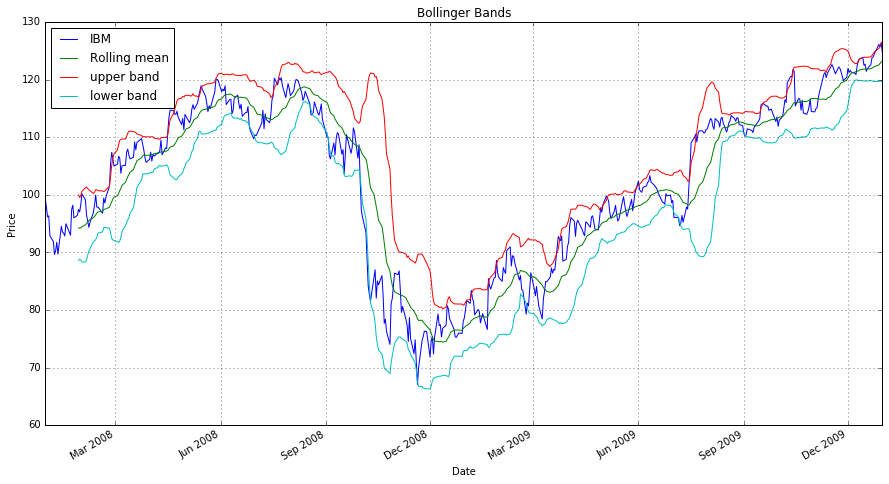

,IBM,rolling_mean,upper_band,lower_band
2009-12-24,124.44,122.2245,124.809073,119.639927
2009-12-28,126.10,122.5395,125.400744,119.678256
2009-12-29,125.66,122.8015,125.801825,119.801175
2009-12-30,126.35,123.0220,126.382342,119.661658
2009-12-31,124.76,123.1980,126.533996,119.862004


In [3]:
prices_all = get_data([stock], dates)
df = get_bollinger_bands(prices_all[stock])
df.tail()

### Apply Bollinger Strategy

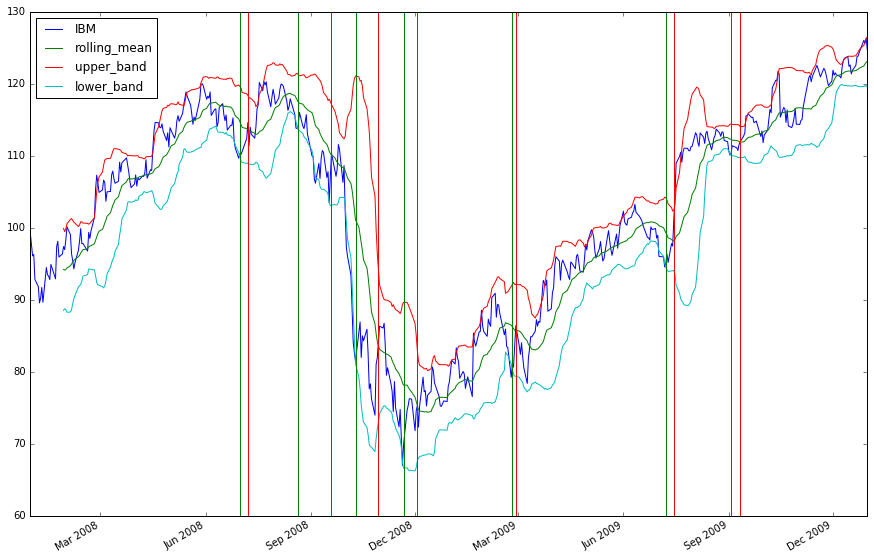

In [4]:
long_entries = []
short_entries = []
exits = []
holding_long = False
holding_short = False

if make_file_out_unique:
    time_now = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = os.path.join(folder_output, '{}_{}.csv'.format(file_output, time_now))
else:
    file_name = os.path.join(folder_output, '{}.csv'.format(file_output))

f = open(file_name,'w')
f.write("Date,Symbol,Order,Shares,Price\n")

for (index1, row1),(index2, row2) in izip(df.iterrows(), df[1:].iterrows()):
    #print index1, row1['IBM'], index2, row2['IBM']
    
    # Signal to buy
    if (row1[stock] < row1['lower_band'] and row2[stock] > row2['lower_band'] and not holding_long):
        long_entries.append(str(index2)[:10])
        holding_long = True
        f.write("{},{},BUY,{},{}\n".format(str(index2)[:10], stock, shares, row2[stock]))
   
    # Signal to sell
    elif (row1[stock] < row1['rolling_mean'] and row2[stock] > row2['rolling_mean'] and holding_long):
        exits.append(str(index2)[:10])
        holding_long = False
        f.write("{},{},SELL,{},{}\n".format(str(index2)[:10], stock, shares, row2[stock]))

'''     
    # Signal to start shorting
    elif (row1[stock] > row1['upper_band'] and row2[stock] < row2['upper_band'] and not holding_short):
        short_entries.append(str(index2)[:10])
        holding_short = True    
        f.write("{},{},SELL,100\n".format(str(index2)[:10], stock))
        
    # Signal to stop shorting     
    elif (row1[stock] > row1['rolling_mean'] and row2[stock] < row2['rolling_mean'] and holding_short):
        exits.append(str(index2)[:10])
        holding_short = False     
        f.write("{},{},BUY,100\n".format(str(index2)[:10], stock))
'''

f.close()       

# Plot Bollinger Strategy
ax = df.plot(figsize=(15, 10))

for day in long_entries:
    ax.axvline(x=day, color='green')
for day in exits:
    ax.axvline(x=day, color='red')
'''
for day in short_entries:
    ax.axvline(x=day, color='red')
'''  
plt.show()

### Back-Testing

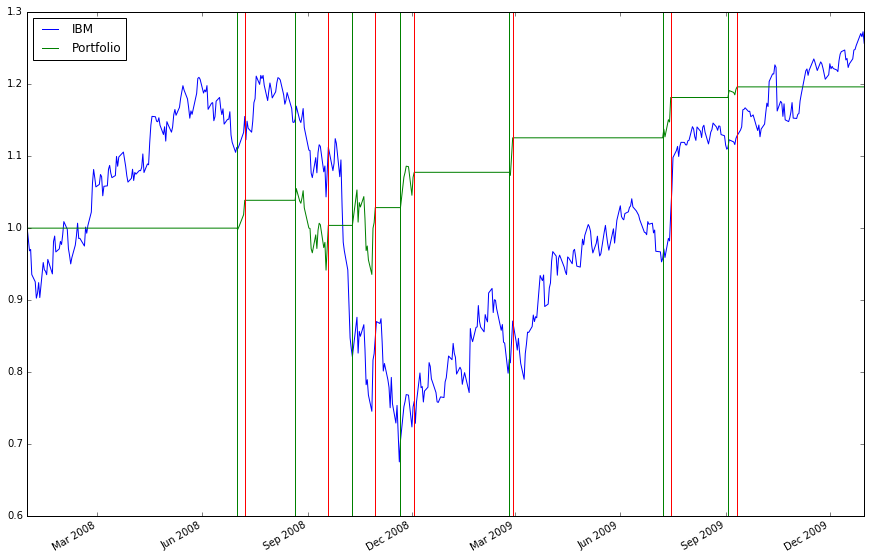

Sharpe Ratio of Fund: 0.794623798448
Sharpe Ratio of IBM: 0.513225764555

Cumulative Return of Fund: 0.196195652174
Cumulative Return of IBM: 0.256774453511

Standard Deviation of Fund: 0.0076555418756
Standard Deviation of IBM: 0.0203041081387

Average Daily Return of Fund: 0.000383210353075
Average Daily Return of IBM: 0.000656435557614

Initial Portfolio Value: 11040.0
Final Portfolio Value: 13206.0
Final Portfolio Return: 2166.0
Final IBM Return: 2549.0


In [5]:
simulate_strategy(date_start, date_end, folder_output, file_output)